In [1]:
import requests 
import pandas as pd 
import numpy as np 
import sqlite3 as sql
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
token = {"token": "grFKsnCcYonzIIzMvVSWglEtnBrsHupz"} #shscai token

base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data?"


url_param = {"datasetid": "GHCND", 
             "datatypeid": "PRCP", 
             "stationid": "GHCND:USW00024213", 
             "startdate": "2000-01-01", 
             "enddate": "2000-01-01", 
             "format": "json", 
             "units": "standard"}

In [3]:
months = [str(i).zfill(2) for i in range(1, 13)]
days = ["31", "28", "31", "30", "31", "30", "31", "31", "30", "31", "30", "31"]
starts = ["{}-01".format(months[i]) for i in range(12)]
ends = ["{}-{}".format(months[i], days[i]) for i in range(12)]

In [4]:
def get_noaa(url, header): 
    r = requests.get(url, headers = header)
    return r

def join_url():
    a = [[param, url_param.get(param)] for param in url_param]
    b = ''.join(['{}={}&'.format(*pair) for pair in a])[:-1]
    return base_url + b

def url_next_year():
    tmp = url_param["startdate"]
    start = url_param["startdate"].split("-")[0]
    start = str(int(start) + 1)
    url_param["startdate"] = start + tmp[4:]
    
    tmp = url_param["enddate"]
    end = url_param["enddate"].split("-")[0]
    end = str(int(end) + 1)
    url_param["enddate"] = end + tmp[4:]

def reset_dates():
    url_param["startdate"] = "2000-01-01"
    url_param["enddate"] = "2000-01-01"

In [5]:
def extract_noaa(listname):
    reset_dates()
    for i in range(12):
        url_param["startdate"] = url_param["startdate"][:5] + starts[i]
        url_param["enddate"] = url_param["enddate"][:5] + ends[i]
        req_url = join_url()

        api_out = get_noaa(req_url, token).json() 
        try:    
            df = pd.DataFrame(api_out["results"])
            listname.append(df[["date", "datatype", "value"]])
        except: 
            continue
    print("city extraction completed")
        
def change_station(station):
    url_param["stationid"] = station      

def format_df(listname, station_name):
    df = pd.concat(listname)
    colname = list(df["datatype"])[0]
    df = df.rename(columns={"value": "{}_{}".format(colname, station_name)})
    df = df.drop(labels = ["datatype"], axis = 1)
    return df

In [6]:
## Eureka
eu_list = []
# no need to change station, first one is already set.
extract_noaa(eu_list)
eu_df = format_df(eu_list, "Eureka")

## Santa Cruz
sc_list = []
change_station("GHCND:USW00024213")
extract_noaa(sc_list)
sc_df = format_df(sc_list, "SantaCruz")

## Santa Maria
sm_list = []
change_station("GHCND:USW00023273")
extract_noaa(sm_list)
sm_df = format_df(sm_list, "SantaMaria")

## Los Angeles
la_list = []
change_station("GHCND:USW00093134")
extract_noaa(la_list)
la_df = format_df(la_list, "LosAngeles")

## San Diego
sd_list = []
change_station("GHCND:USW00023188")
extract_noaa(sd_list)
sd_df = format_df(sd_list, "SanDiego")

city extraction completed
city extraction completed
city extraction completed
city extraction completed
city extraction completed


In [7]:
prcp_df = eu_df.merge(sc_df, how = "outer").merge(sm_df, how = "outer")\
          .merge(la_df, how = "outer").merge(sd_df, how = "outer")
prcp_df

,date,PRCP_Eureka,PRCP_SantaCruz,PRCP_SantaMaria,PRCP_LosAngeles,PRCP_SanDiego
0,2000-01-01T00:00:00,0.28,0.28,0.0,0.0,0.03
1,2000-01-02T00:00:00,0.23,0.23,0.0,0.0,0.00
2,2000-01-03T00:00:00,0.00,0.00,0.0,0.0,0.00
3,2000-01-04T00:00:00,0.39,0.39,0.0,0.0,0.00
4,2000-01-05T00:00:00,0.00,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...
295,2000-12-21T00:00:00,0.29,0.29,0.0,0.0,0.00
296,2000-12-22T00:00:00,0.17,0.17,0.0,0.0,0.00
297,2000-12-23T00:00:00,0.25,0.25,0.0,0.0,0.00
298,2000-12-24T00:00:00,0.00,0.00,0.0,0.0,0.00


In [8]:
date_str = [d.replace("-", "")[:8] for d in prcp_df["date"]]
prcp_df["datetime"] = [dt.strptime(d, "%Y%m%d") for d in date_str]
prcp_df = prcp_df.set_index("datetime").drop("date", axis = 1)

prcp_df.to_csv("prcp.csv", encoding='utf-8')

In [9]:
norm_prcp = (prcp_df-prcp_df.mean())/prcp_df.std()

## Salinity, Fugacity, etc.

In [10]:
# salinity api 

# https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20000102&range=24&station=9414290&product=salinity&units=metric&time_zone=gmt&application=ports_screen&format=csv
## I was having trouble with doing this with requests in python for some reason,
## csv obtained from cURL api requests in terminal 

df = pd.read_csv("SALINITY.csv")

| Column Number | Variable Name | Description |
| -- | :--- | :---------- |
| 1. | GROUP/SHIP | AOML_Brown for all underway data from the Ron Brown. |
| 2. | CRUISE_DESIGNATION | Cruise ID (e.g., RBYYYYnn where RB = Ron Brown, YYYY = the four digit year, and nn = the cruise number for that year). | 
| 3. | JD_GMT | Decimal year day. |
| 4. | DATE_DDMMYYYY | GMT date.  The date format has been changed to comply with the IOCCP recommendations. |
| 5. | TIME_HH:MM:SS | GMT time. |
| 6. | LAT_DEC_DEGREE | Latitude in decimal degrees (negative values are in the southern hemisphere). |
| 7. | LONG_DEC_DEGREE | Longitude in decimal degrees (negative values are in the western hemisphere). |
| 8. | xCO2W_PPM | Mole fraction of CO2 (dry) in the equilibrator headspace at equilibrator temperature (Teq) in parts per million. | 
| 9. | xCO2A_PPM | Mole fraction of CO2 in air in parts per million. | 
| 10. | EqTEMP_C | Temperature in equilibrator water in degrees centigade. Temperature in equilibrator measured with a calibrated thermistor. | 
| 11. | PRES_EQUIL_hPa | Barometric pressure in the lab in hectopascals (1 hectopascal = 1 millibar). | 
| 12. | SST(TSG)_C: | Temperature from the ship's thermosalinograph in degrees centigrade. |
| 13. | SAL(TSG)_PERMIL | Salinity from the ship's thermosalinograph on the Practical Salinity Scale. | 
| 14. | fCO2w,eq | Fugacity of CO2 in the equilibrator in microatmospheres calculated as outlined below. |
| 15. | fCO2W@SST_uatm | Fugacity of CO2 in sea water in microatmospheres calculated as outlined below. | 
| 16. | fCO2A_uATM | Fugacity of CO2 in air in microatmospheres calculated as outlined below. | 
| 17. | dfCO2_uatm | Sea water fCO2 - air fCO2 in microatmospheres. This uses the average air value for the current hour. | 

### Cleaning

In [11]:
df = df.drop(labels = ["GROUP/SHIP", "CRUISE_DESIGNATION", "JD_GMT", "TIME_HH:MM:SS"], axis = 1)

In [12]:
df

,DATE_DDMMYYYY,LAT_DEC_DEGREE,LONG_DEC_DEGREE,xCO2W_PPM,xCO2A_PPM,EqTEMP_C,PRES_EQUIL_hPa,SST(TSG)_C,SAL(TSG)_PERMIL,"fCO2w,eq",fCO2W@SST_uATM,fCO2A_uATM,dfCO2_uATM
0,18032000,47.726,-126.424,-999.99,375.75,9.11,1012.60,8.69,32.59,-999.99,-999.99,369.63,-999.99
1,18032000,47.719,-126.440,-999.99,375.75,9.09,1012.07,8.69,32.59,-999.99,-999.99,369.63,-999.99
2,18032000,47.712,-126.455,-999.99,375.75,9.09,1012.12,8.67,32.58,-999.99,-999.99,369.63,-999.99
3,18032000,47.704,-126.471,-999.99,375.75,9.09,1011.93,8.67,32.59,-999.99,-999.99,369.63,-999.99
4,18032000,47.676,-126.525,-999.99,375.75,9.06,1011.61,8.64,32.59,-999.99,-999.99,369.63,-999.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20873,13112000,11.803,-94.333,437.40,367.80,28.57,1011.20,28.50,33.18,418.73,417.65,352.03,65.63
20874,13112000,11.797,-94.316,437.31,367.80,28.51,1011.17,28.50,33.21,418.63,418.43,352.03,66.40
20875,13112000,11.790,-94.298,437.91,367.80,28.58,1011.11,28.58,33.19,419.11,419.11,352.03,67.08
20876,13112000,11.767,-94.236,440.83,-999.99,28.72,1011.19,28.60,33.21,421.92,420.05,-999.99,-999.99


In [13]:
df = df.rename(columns={"DATE_DDMMYYYY": "date", 
                        "LAT_DEC_DEGREE": "lat", 
                        "LONG_DEC_DEGREE": "long", 
                        "xCO2W_PPM": "co2_eq",
                        "xCO2A_PPM": "co2_air", 
                        "EqTEMP_C": "temp_eq",
                        "PRES_EQUIL_hPa": "pressure",
                        "SST(TSG)_C": "temp_therm", 
                        "SAL(TSG)_PERMIL": "salinity", 
                        "fCO2w,eq": "fug_eq",
                        "fCO2W@SST_uATM": "fug_sea", 
                        "fCO2A_uATM": "fug_air", 
                        "dfCO2_uATM": "fco2_sea"})

| Column Number | Variable Name | Description |
| -- | :--- | :---------- |
| 1 | date | GMT date.  The date format has been changed to comply with the IOCCP recommendations. |
| 2 | lat | Latitude in decimal degrees (negative values are in the southern hemisphere). |
| 3 | long | Longitude in decimal degrees (negative values are in the western hemisphere). |
| 4 | co2_eq | Mole fraction of CO2 (dry) in the equilibrator headspace at equilibrator temperature (Teq) in parts per million. | 
| 5 | co2_air | Mole fraction of CO2 in air in parts per million. | 
| 6 | temp_eq | Temperature in equilibrator water in degrees centigade. Temperature in equilibrator measured with a calibrated thermistor. | 
| 7 | pressure | Barometric pressure in the lab in hectopascals (1 hectopascal = 1 millibar). | 
| 8 | temp_therm | Temperature from the ship's thermosalinograph in degrees centigrade. |
| 9 | salinity | Salinity from the ship's thermosalinograph on the Practical Salinity Scale. | 
| 10 | fug_eq | Fugacity of CO2 in the equilibrator in microatmospheres calculated as outlined below. |
| 11 | fug_sea | Fugacity of CO2 in sea water in microatmospheres calculated as outlined below. | 
| 12 | fug_air | Fugacity of CO2 in air in microatmospheres calculated as outlined below. | 
| 13 | fco2_sea | Sea water fCO2 - air fCO2 in microatmospheres. This uses the average air value for the current hour. | 

#### NA

In [14]:
df = df.replace( -999.99, np.nan)

#### Locations 

These coastal locations have been selected because there are data points in both the NCEI oceans dataset and the NOAA monthly summaries dataset. 

| Location | Latitude | Longitude |
| --- | --- | --- |
| Eureka | 40.79 | -124.17 | 
| Santa Cruz | 36.97 | -122.03 |
| Santa Maria | 34.94 | -120.43 |
| Los Angeles | 34.03 | -118.23 |
| San Diego | 32.7 | -117.15 | 

In [15]:
ca_list = []
lat_long = {"Eureka": [40.79, -124.17], 
            "Santa Cruz": [36.97, -122.03],
            "Santa Maria": [34.94, -120.43],
            "Los Angeles": [34.03, -118.23],
            "San Diego": [32.7, -117.15]}

for place in lat_long:
    lat, long = lat_long[place]
    tmp = df.loc[(lat-5 <= df['lat']) & (df['lat'] <= lat+5) & (long-5 <= df['long']) & (df["long"] <= long+5)]
    city = [place] * tmp.shape[0] 
    tmp.insert(3, "city", city, True)
    ca_list.append(tmp)
    
ca_df = pd.concat(ca_list).reset_index().drop("index", axis = 1)
ca_df

,date,lat,long,city,co2_eq,co2_air,temp_eq,pressure,temp_therm,salinity,fug_eq,fug_sea,fug_air,fco2_sea
0,21032000,43.354,-129.158,Eureka,334.13,371.61,10.24,1025.64,9.79,32.79,333.00,326.58,370.39,-43.81
1,21032000,43.358,-129.137,Eureka,333.99,371.61,10.23,1025.73,9.79,32.78,332.89,326.61,370.39,-43.78
2,21032000,43.375,-129.061,Eureka,334.43,371.61,10.25,1025.80,9.80,32.80,333.35,326.99,370.39,-43.40
3,21032000,43.379,-129.040,Eureka,334.89,371.61,10.18,1025.81,9.76,32.79,333.82,327.79,370.39,-42.60
4,21032000,43.384,-129.020,Eureka,335.09,371.61,10.05,1025.80,9.61,32.77,334.05,327.80,370.39,-42.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,18102000,27.818,-115.722,San Diego,396.98,370.44,19.27,1014.82,18.94,33.67,387.85,382.77,361.83,20.94
3387,18102000,27.758,-115.703,San Diego,394.75,370.44,19.41,1014.75,19.09,33.68,385.57,380.65,361.83,18.82
3388,18102000,27.742,-115.698,San Diego,392.85,370.44,20.17,1014.70,19.75,33.72,383.36,377.00,361.83,15.17
3389,18102000,27.726,-115.692,San Diego,388.09,370.44,20.50,1014.98,20.32,33.78,378.52,375.87,361.83,14.04


#### Date Format

In [16]:
date_str = [str(d).zfill(8) for d in ca_df["date"]]
ca_df["datetime"] = [dt.strptime(d, "%d%m%Y") for d in date_str]
ca_df = ca_df.set_index("datetime")

df_date_str = [str(d).zfill(8) for d in df["date"]]
df["datetime"] = [dt.strptime(d, "%d%m%Y") for d in df_date_str]
df = df.set_index("datetime")

In [17]:
ca_df

,date,lat,long,city,co2_eq,co2_air,temp_eq,pressure,temp_therm,salinity,fug_eq,fug_sea,fug_air,fco2_sea
datetime,,,,,,,,,,,,,,
2000-03-21,21032000,43.354,-129.158,Eureka,334.13,371.61,10.24,1025.64,9.79,32.79,333.00,326.58,370.39,-43.81
2000-03-21,21032000,43.358,-129.137,Eureka,333.99,371.61,10.23,1025.73,9.79,32.78,332.89,326.61,370.39,-43.78
2000-03-21,21032000,43.375,-129.061,Eureka,334.43,371.61,10.25,1025.80,9.80,32.80,333.35,326.99,370.39,-43.40
2000-03-21,21032000,43.379,-129.040,Eureka,334.89,371.61,10.18,1025.81,9.76,32.79,333.82,327.79,370.39,-42.60
2000-03-21,21032000,43.384,-129.020,Eureka,335.09,371.61,10.05,1025.80,9.61,32.77,334.05,327.80,370.39,-42.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-18,18102000,27.818,-115.722,San Diego,396.98,370.44,19.27,1014.82,18.94,33.67,387.85,382.77,361.83,20.94
2000-10-18,18102000,27.758,-115.703,San Diego,394.75,370.44,19.41,1014.75,19.09,33.68,385.57,380.65,361.83,18.82
2000-10-18,18102000,27.742,-115.698,San Diego,392.85,370.44,20.17,1014.70,19.75,33.72,383.36,377.00,361.83,15.17


#### Daily Average

In [18]:
mean_df = df.groupby("datetime").mean()

#### Normalize Data

In [19]:
norm_df = df.copy(deep=True)
norm_df.iloc[:,3:] = norm_df.iloc[:,3:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [20]:
norm_df

,date,lat,long,co2_eq,co2_air,temp_eq,pressure,temp_therm,salinity,fug_eq,fug_sea,fug_air,fco2_sea
datetime,,,,,,,,,,,,,
2000-03-18,18032000,47.726,-126.424,NaN,1.542197,-1.107826,-0.927559,-1.099777,-0.345540,NaN,NaN,1.023757,NaN
2000-03-18,18032000,47.719,-126.440,NaN,1.542197,-1.111001,-1.021375,-1.099777,-0.345540,NaN,NaN,1.023757,NaN
2000-03-18,18032000,47.712,-126.455,NaN,1.542197,-1.111001,-1.012524,-1.102888,-0.355036,NaN,NaN,1.023757,NaN
2000-03-18,18032000,47.704,-126.471,NaN,1.542197,-1.111001,-1.046156,-1.102888,-0.345540,NaN,NaN,1.023757,NaN
2000-03-18,18032000,47.676,-126.525,NaN,1.542197,-1.115763,-1.102800,-1.107555,-0.345540,NaN,NaN,1.023757,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-11-13,13112000,11.803,-94.333,0.959735,-0.252381,1.981255,-1.175374,1.981707,0.214744,0.809270,0.873285,-1.477859,1.014653
2000-11-13,13112000,11.797,-94.316,0.958284,-0.252381,1.971730,-1.180684,1.981707,0.243233,0.807580,0.886462,-1.477859,1.027136
2000-11-13,13112000,11.790,-94.298,0.967958,-0.252381,1.982842,-1.191305,1.994151,0.224241,0.815693,0.897950,-1.477859,1.038159


### Plots

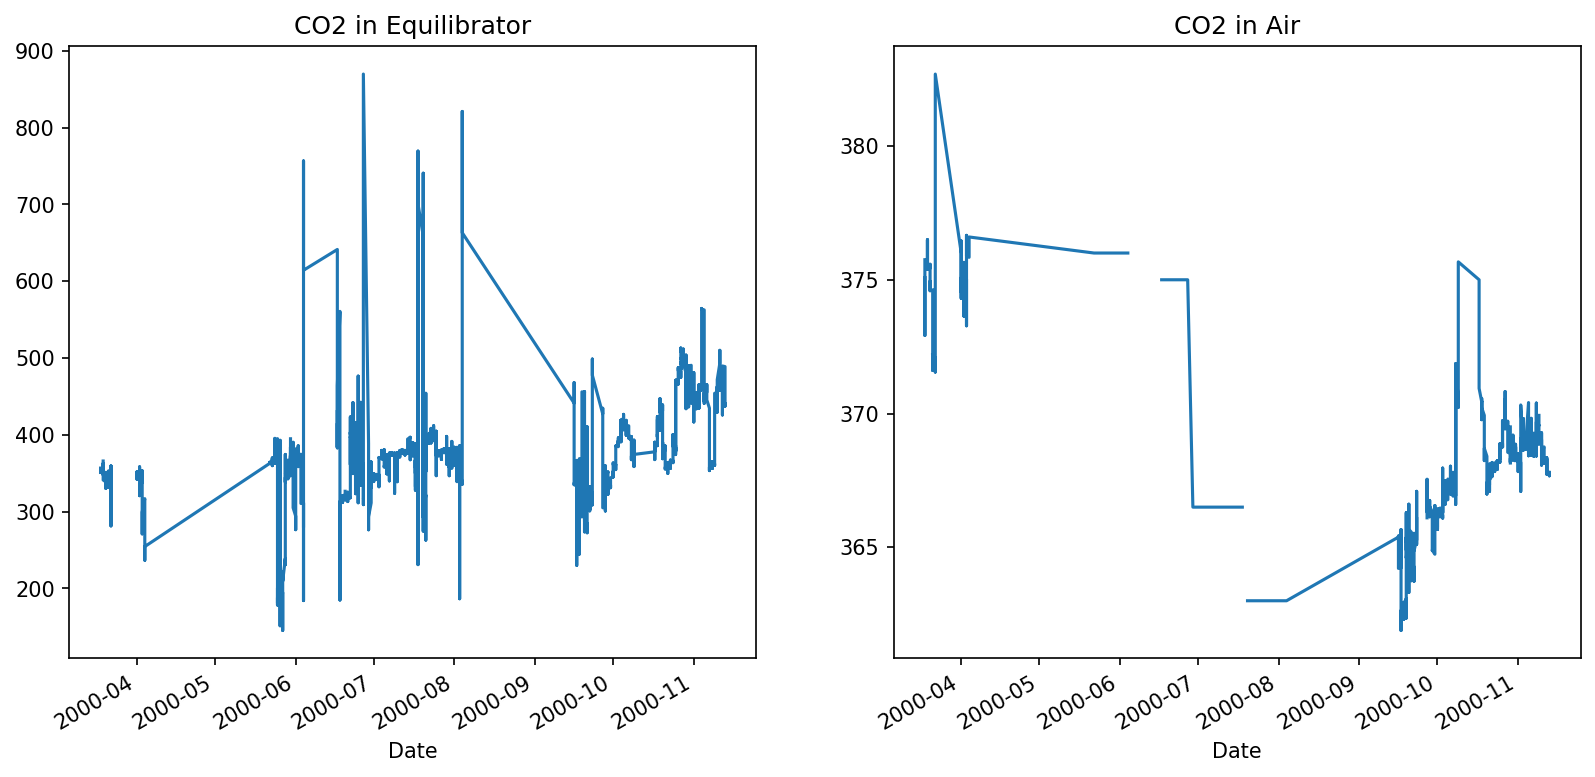

In [21]:
plt.figure(figsize=(13, 6), dpi=150)
plt.subplot(1, 2, 1)
df["co2_eq"].plot()
plt.title('CO2 in Equilibrator')
plt.xlabel('Date')
plt.subplot(1, 2, 2)
df["co2_air"].plot()
plt.title('CO2 in Air')
plt.xlabel('Date')
plt.show()

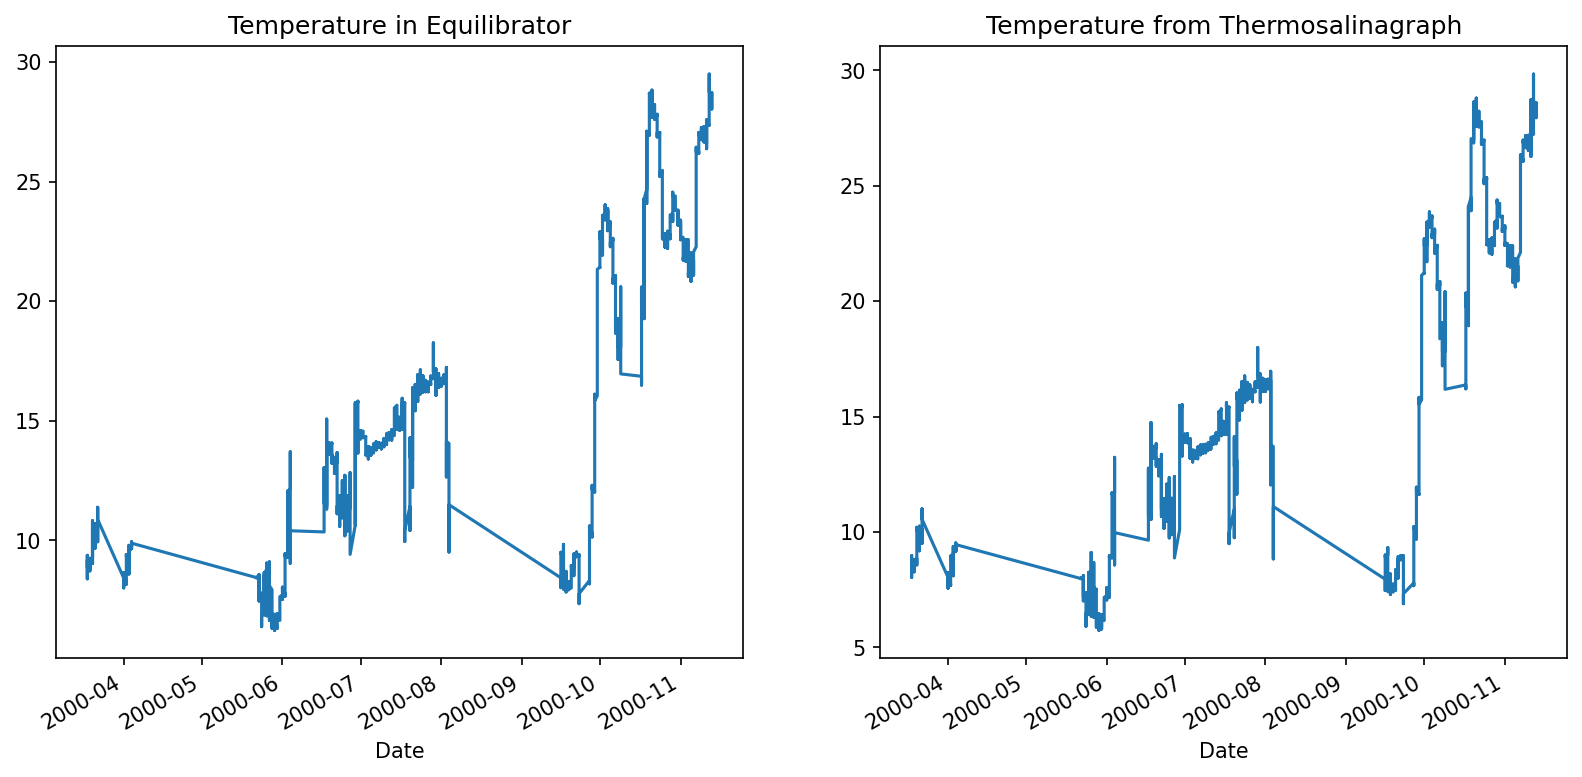

In [22]:
plt.figure(figsize=(13, 6), dpi=150)
plt.subplot(1, 2, 1)
df["temp_eq"].plot()
plt.title('Temperature in Equilibrator')
plt.xlabel('Date')
plt.subplot(1, 2, 2)
df["temp_therm"].plot()
plt.title('Temperature from Thermosalinagraph')
plt.xlabel('Date')
plt.show()

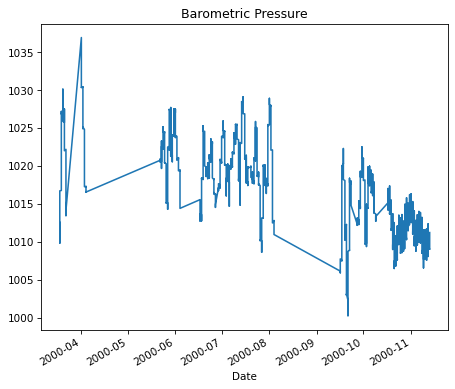

In [23]:
plt.figure(figsize=(7, 6), dpi=75)
df["pressure"].plot()
plt.title('Barometric Pressure')
plt.xlabel('Date')
plt.show()

In [26]:
err = df.loc[df["salinity"] == min(df["salinity"])].index
df = df.drop(err)

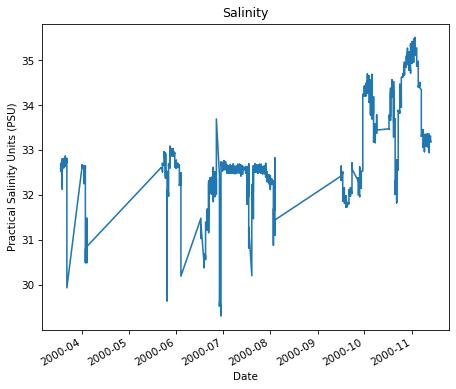

In [27]:
plt.figure(figsize=(7, 6), dpi=75)
df["salinity"].plot();
plt.title('Salinity')
plt.xlabel('Date')
plt.ylabel("Practical Salinity Units (PSU)")
plt.show()

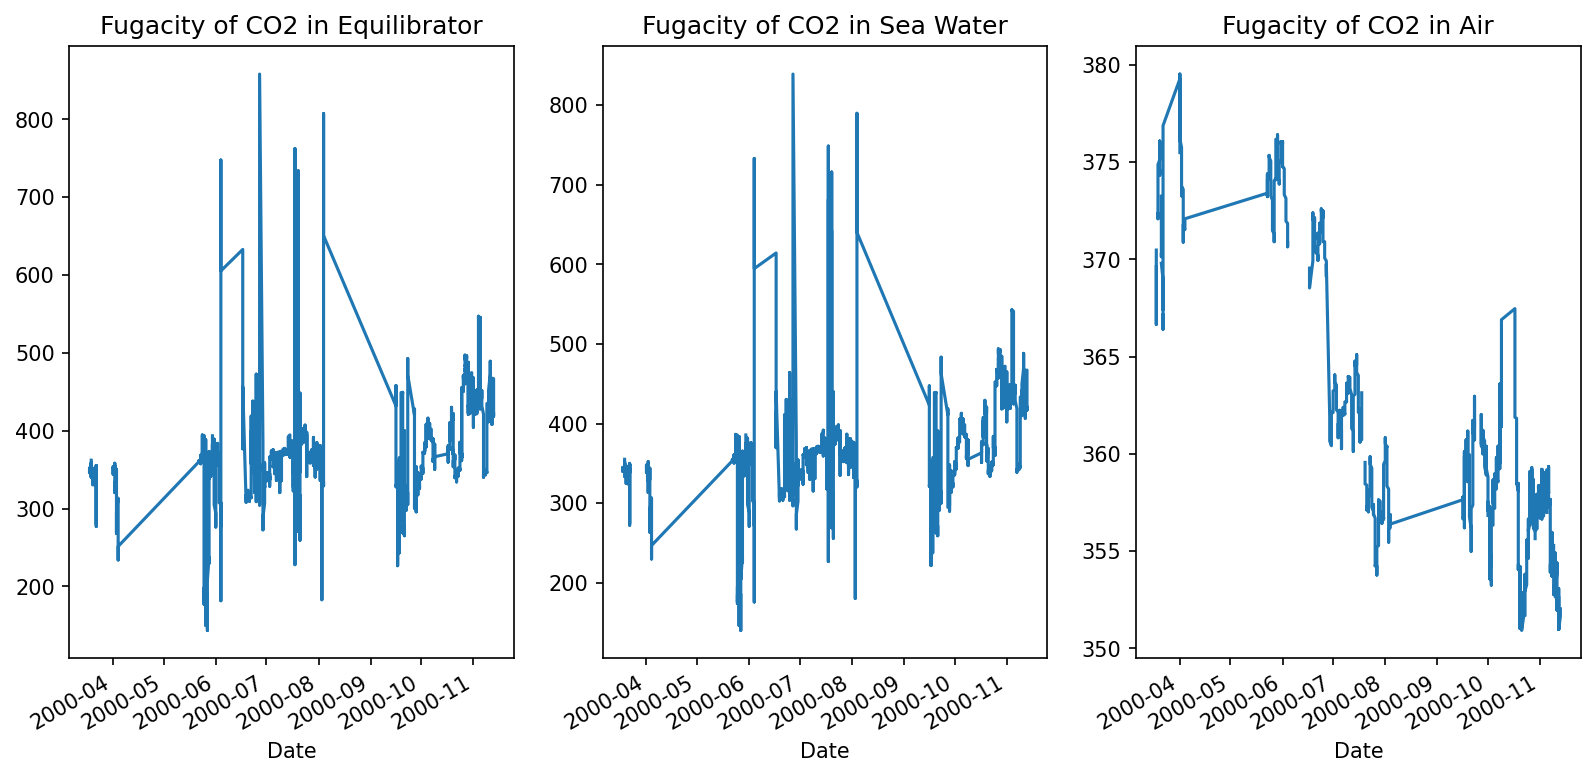

In [28]:
plt.figure(figsize=(13, 6), dpi=150)
plt.subplot(1, 3, 1)
df["fug_eq"].plot()
plt.title('Fugacity of CO2 in Equilibrator')
plt.xlabel('Date')
plt.subplot(1, 3, 2)
df["fug_sea"].plot()
plt.title('Fugacity of CO2 in Sea Water')
plt.xlabel('Date')
plt.subplot(1, 3, 3)
df["fug_air"].plot()
plt.title('Fugacity of CO2 in Air')
plt.xlabel('Date')
plt.show()